In [100]:
import pandas as pd
import os
import re
import sys
import json
import baltic as bt
import random
from collections import defaultdict, Counter
import dendropy
import math

In [134]:
def summary_json(main_folder, output_folder, output, majority_threshold):

    def compute_entropy(prob_dict):
        return -sum(p * math.log2(p) for p in prob_dict.values() if p > 0)
    
    def binary_entropy(p_true, p_false):
        
        H = 0.0
        if p_true > 0:
            H -= p_true * math.log2(p_true)
        if p_false > 0:
            H -= p_false * math.log2(p_false)
            
        return H

    rep_folders = [folder for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

    n_jsons = len(rep_folders)

    node_annotations_summary = defaultdict(lambda: {
        'reassorted': 0,
        'nonreassorted': 0,
        'rea': defaultdict(int),
        'divergence': defaultdict(Counter)
    })

    for rep_folder in rep_folders:

        rep_path = os.path.join(main_folder, rep_folder)
        rea_output = next(file for file in os.listdir(rep_path) if file.endswith('.json'))

        rea_path = os.path.join(rep_path, rea_output)

        with open(rea_path) as f:
            rea_data = json.load(f)

        for node, annotations in rea_data.get("nodes", {}).items():

            is_reassorted = annotations.get("Reassorted", "False") == "True"
            if is_reassorted:
                node_annotations_summary[node]['reassorted'] += 1
                seg_str = annotations.get("Reassorted Segments", "")
                div_str = annotations.get("Divergence Value", "")


                # Extract segments: from "3 (PB2, PB1, NP)" → ["PB2", "PB1", "NP"]
                seg_match = re.search(r'\(([^)]+)\)', seg_str)
                segments = [s.strip() for s in seg_match.group(1).split(',')] if seg_match else []

                # Extract divergence values: from "344, 319, 264" → [344, 319, 264]
                divergence_values = [int(v.strip()) for v in div_str.split(',') if v.strip()]

                # Map segment ↔ divergence value
                if len(segments) == len(divergence_values):
                    for seg, div in zip(segments, divergence_values):
                        node_annotations_summary[node]['rea'][seg] += 1
                        node_annotations_summary[node]['divergence'][seg][div] += 1
            else:
                node_annotations_summary[node]['nonreassorted'] += 1

    formatted_annotations = {"nodes":{}}
    
    for node, counts in node_annotations_summary.items():
        reassorted_count = counts['reassorted']
        nonreassorted_count = counts['nonreassorted']
        confidence_true = reassorted_count / n_jsons
        confidence_false = nonreassorted_count / n_jsons

        reassorted_final = confidence_true >= majority_threshold

        segment_confidence = {
            seg: counts['rea'][seg] / reassorted_count for seg in counts['rea']
        }
        
        high_conf_segments = [seg for seg, conf in segment_confidence.items() if conf >= majority_threshold]
        
        divergence_mode = {}
        divergence_confidence = {}
        divergence_entropy = {}
        
        for seg, div_counter in counts['divergence'].items():
            most_common_value, most_common_count = div_counter.most_common(1)[0]
            divergence_mode[seg] = str(most_common_value)
            divergence_confidence[seg] = {
                str(div): round(count / reassorted_count, 5)
                for div, count in div_counter.items()
            }
            entropy_val = compute_entropy(divergence_confidence[seg])
            divergence_entropy[seg] = round(entropy_val, 5)
            
            
        segment_entropy = compute_entropy(segment_confidence)
        reassorted_entropy = binary_entropy(confidence_true, confidence_false)

        # just as a fail-safe, if reassorted is True but no segment reaches the majority_threshold, 
        # list the most frequently reassorting segment
        if reassorted_final and not high_conf_segments:
            top_seg = max(segment_confidence.items(), key=lambda x: x[1])[0]
            high_conf_segments = [top_seg]

        formatted_annotations["nodes"][node] = {
            "reassorted": str(reassorted_final),
            "reassorted_confidence": {
                "True": round(confidence_true, 5),
                "False": round(confidence_false, 5)
            },
            "reassorted_entropy": round(reassorted_entropy, 5),
            "segments": ", ".join(sorted(high_conf_segments)) if reassorted_final else '',
            "segments_confidence": {
                seg: round(conf, 5) for seg, conf in segment_confidence.items()
            },
            "segments_entropy": round(segment_entropy, 5),
            "divergence": ", ".join(
                    f"{seg}({divergence_mode[seg]})" for seg in high_conf_segments
                ) if reassorted_final else "",
            "divergence_confidence": {
                seg: conf for seg, conf in divergence_confidence.items()
            },
            "divergence_entropy": divergence_entropy
        }
    

    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    else:
        pass
    
    with open(f"{output_folder}/{output}", 'w') as out_f:
        json.dump(formatted_annotations, out_f, indent=4)


In [135]:
# summary_json('./results', 'summary_95_CV', 'summary_reassortment.json', 0.95)

In [136]:
''' 
this makes a summary tree (in both nexus and nwk formats)
without any confidence values for fast visualization

json with confidence values will be supplied as node_data for augur export

'''

def treesort_QC(qc_input, qc_output):
    
    with open(qc_input, 'r') as file:
        modified = file.read()
        
    # removing commas between segments
    modified = re.sub(r'&rea="([^"]+)"', lambda match: f'&rea="{match.group(1).replace(",", "-")}"', modified)
    
    # removing quotation marks around node names
    modified = re.sub(r"'(TS_NODE_\d+)'", r'\1', modified)
    
    # replacing ? with _ so baltic can read it in
    modified = modified.replace('?', '_')
    
    with open(qc_output, "w") as output_file:
        output_file.write(modified.strip())

def summary_tree(summary_folder, summary_json, tree_path):
    
    with open(f"{summary_folder}/{summary_json}") as f:
        summary_data = json.load(f)
    
    tree = dendropy.Tree.get(
        path=tree_path,
        schema="newick",
        preserve_underscores=True)
    
    for node in tree.preorder_node_iter():
    
        label = str(node.taxon).replace('Taxon(', '').strip(')"\'') if node.is_leaf() else node.label

        if label in summary_data:

            info = summary_data[label]
            node.annotations.clear()
            
            is_reassorted = 1 if info["reassorted"] == "True" else 0
            node.annotations.add_new("is_reassorted", is_reassorted)
            
            if info["segments"]:
                node.annotations.add_new("rea", info["segments"])
            
    tree.write(path=f"{summary_folder}/summary.nwk", schema="newick", suppress_annotations = False)
    tree.write(path=f"{summary_folder}/summary.nexus", schema="nexus", suppress_annotations = False)
    
    treesort_QC(f"{summary_folder}/summary.nwk", f"{summary_folder}/summary_baltic.nwk")
    mytree = bt.loadNewick(f"{summary_folder}/summary_baltic.nwk", absoluteTime= False)
    
    return(mytree)
    

In [137]:
mytree = summary_tree('summary_95_CV', 'summary_reassortment.json', 'data/ha/output.nwk')

In [138]:
majority_threshold = "95%"
rea_count=0

for k in mytree.Objects:
    if k.traits["is_reassorted"]:
        rea_count+=1
        
print(f"{majority_threshold} cutoff: " + str(rea_count) + " reassortment events")

95% cutoff: 8 reassortment events


In [139]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

def plot_rea(mytree, summary_folder):
    
    plt.rcParams["font.family"] = "Arial"

    fig, ax = plt.subplots(figsize=(15, 15))

    x_attr = lambda k: k.x
    
    color_by = lambda k: "red" if k.traits["is_reassorted"] else "black"

    mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = 3)
    
    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size= 5,
                   colour=color_by,
                   zorder=2,
                   marker='o'
                     )
    
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label='Reassorted'),
        Patch(facecolor='black', edgecolor='black', label='Non-reassorted')
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=25, title_fontsize=30)


    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x',labelsize=30,size=15, width=2,color='grey')
    ax.set_xlabel("Divergence", fontsize=25)
    fig.tight_layout()
     
    plt.savefig(f"{summary_folder}/rea.pdf")
    plt.show()


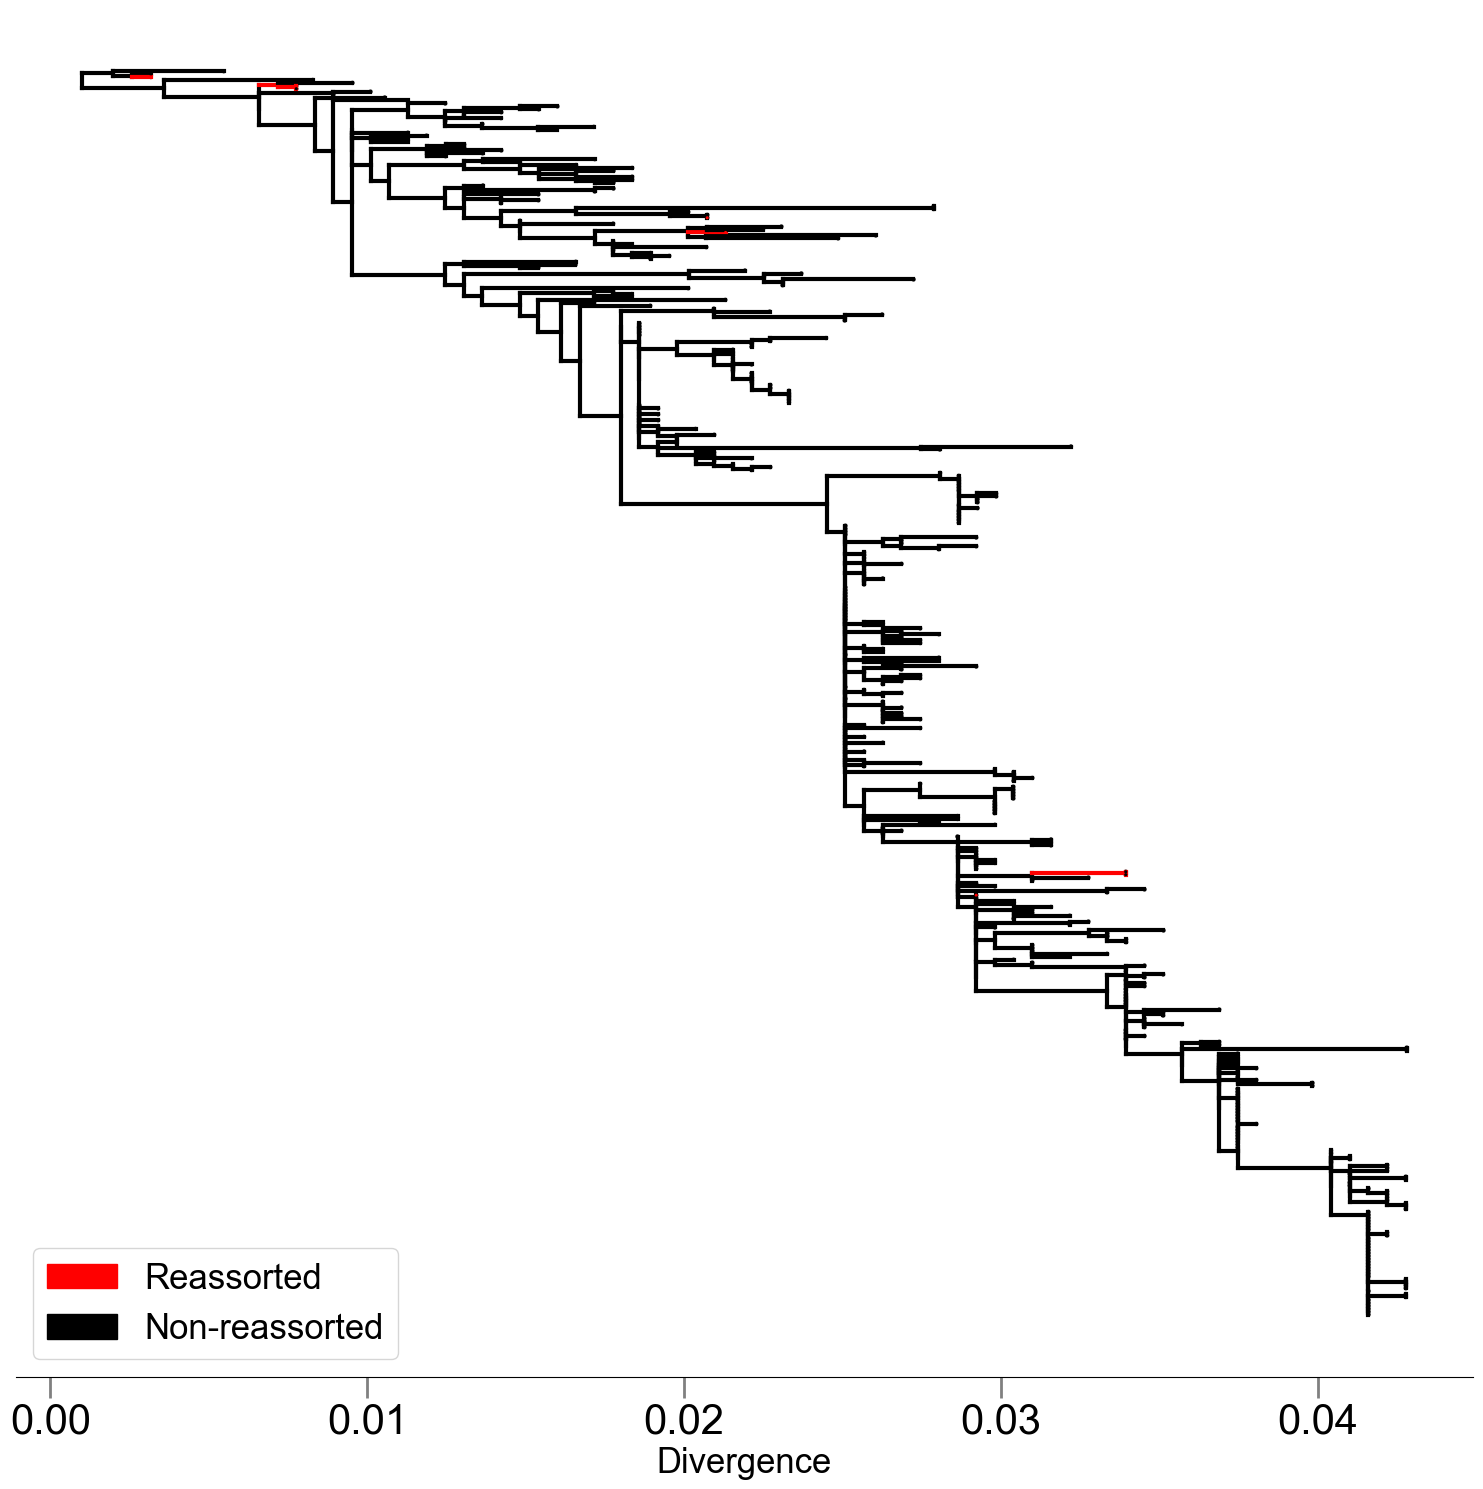

In [140]:
plot_rea(mytree, 'summary_95_CV')